In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
datadir = tf.keras.utils.get_file(fname='flower_photos',origin=dataset_url,untar=True)

datadir = pathlib.Path(datadir)

228827136/228813984 [==============================] - 1s 0us/step


In [3]:
img_count = len(list(datadir.glob('*/*.jpg')))
print(img_count)

3670


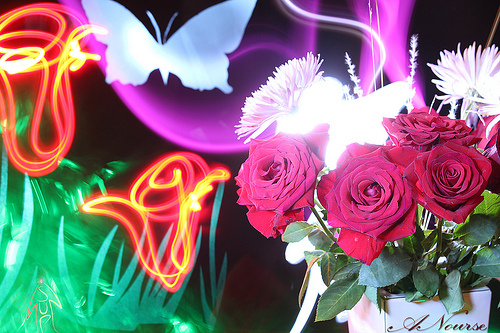

In [4]:
roses = list(datadir.glob('roses/*'))
PIL.Image.open(roses[0])

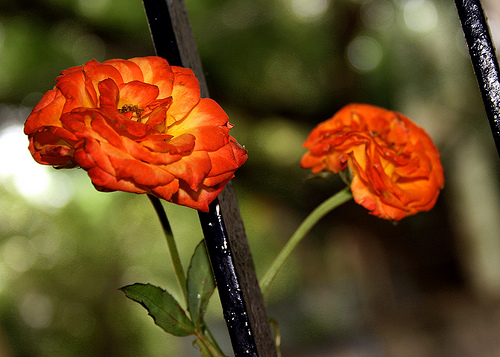

In [5]:
roses = list(datadir.glob('roses/*'))
PIL.Image.open(roses[1])

In [6]:
batch_size = 32
img_width = 180
img_height = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(datadir,
                                                       batch_size=batch_size,
                                                       image_size=(img_width,img_height),
                                                       validation_split=0.2,
                                                       seed=123,
                                                       subset='training')

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
valid_ds = tf.keras.utils.image_dataset_from_directory(datadir,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=123,
                                                       batch_size=batch_size,
                                                       image_size=(img_width,img_height))

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_name = train_ds.class_names
print(class_name)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


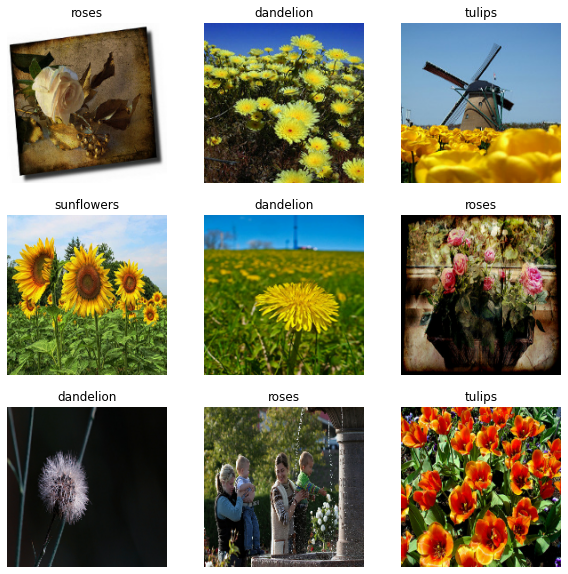

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for Images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(Images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis('off')

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
normalize = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, label_batch = next(iter(normalize))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1/255.0),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(5)
])

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 132s 1s/step - loss: 1.3507 - accuracy: 0.4220 - val_loss: 1.1687 - val_accuracy: 0.5395
Epoch 2/3
92/92 [==============================] - 109s 1s/step - loss: 1.0467 - accuracy: 0.5909 - val_loss: 0.9699 - val_accuracy: 0.6185
Epoch 3/3
92/92 [==============================] - 106s 1s/step - loss: 0.8664 - accuracy: 0.6662 - val_loss: 0.9094 - val_accuracy: 0.6580


In [18]:
list_ds = tf.data.Dataset.list_files(str(datadir /'*/*'), shuffle = False)
list_ds = list_ds.shuffle(img_count, reshuffle_each_iteration = False)

In [19]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/roses/5292988046_a10f4b0365_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/16303377824_6e9128b4bd.jpg'
b'/root/.keras/datasets/flower_photos/tulips/2503489175_f0848d3e8e.jpg'
b'/root/.keras/datasets/flower_photos/roses/12572786553_634868f7f2_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/17862445825_f7031d6f26.jpg'


In [20]:
class_names = np.array(sorted([item.name for item in datadir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [21]:
val_size = int(img_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)


In [22]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [28]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)

In [29]:
def decode_img(img):
  
  img = tf.io.decode_jpeg(img, channels=3)


  return tf.image.resize(img, [img_height, img_width])

In [30]:
def process_path(file_path):
  label = get_label(file_path)
  
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [31]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [32]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


In [33]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

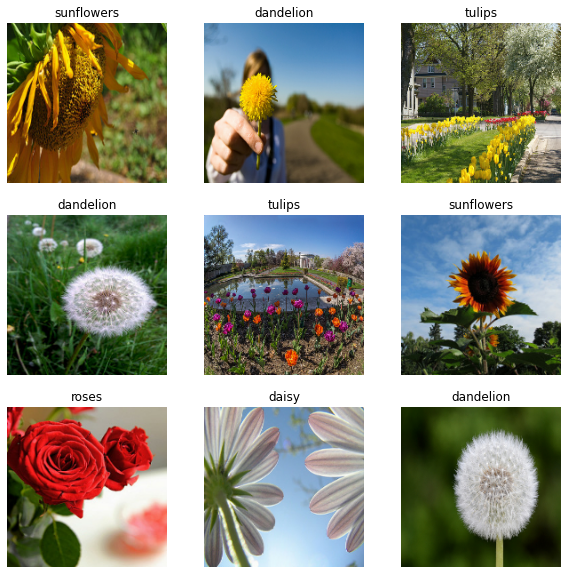

In [34]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [35]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 128s 1s/step - loss: 0.7161 - accuracy: 0.7275 - val_loss: 0.6819 - val_accuracy: 0.7398
Epoch 2/3
92/92 [==============================] - 117s 1s/step - loss: 0.5462 - accuracy: 0.7963 - val_loss: 0.8205 - val_accuracy: 0.6921
Epoch 3/3
92/92 [==============================] - 108s 1s/step - loss: 0.3641 - accuracy: 0.8760 - val_loss: 0.8103 - val_accuracy: 0.7357


In [36]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [37]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


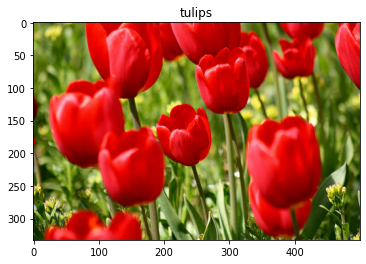

In [38]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [39]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)